# Imports

In [1]:
import pandas as pd
import joblib
import warnings

from resources.context import Context as c
from resources.featureengineering import FeatureEngineering
from resources.plotcreator import PlotCreator

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings(action='ignore')

# Data Load

In [3]:
df0 = pd.read_csv('https://elo7-datasets.s3.amazonaws.com/data_scientist_position/elo7_recruitment_dataset.csv')

# 1.0. Data Description

## 1.1. Shape

In [4]:
df0.shape

(38507, 15)

## 1.2. Dtypes

In [5]:
df0.dtypes # no big mistake located, but some dtypes will be revised after data analysis

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts         float64
category              object
dtype: object

## 1.3. NAs

In [6]:
df0.isna().sum() # will be corrected after data analysis

product_id               0
seller_id                0
query                    0
search_page              0
position                 0
title                    0
concatenated_tags        2
creation_date            0
price                    0
weight                  58
express_delivery         0
minimum_quantity         0
view_counts              0
order_counts         20390
category                 0
dtype: int64

## 1.4. Statistical Description

In [7]:
df_statistics = df0.drop('order_counts', axis=1)
df_statistics = df_statistics.dropna()

In [8]:
data_analysis = PlotCreator(df=df_statistics.drop(['product_id', 'seller_id'], axis=1))
data_analysis.statistical_description(saving_figloc=(c().reports_fld() / 'classification/statistical_description.png'))

[0812/163545.792315:ERROR:sandbox_linux.cc(378)] InitializeSandbox() called with multiple threads in process gpu-process.
[0812/163545.892485:INFO:headless_shell.cc(653)] Written to file /tmp/tmp795n9q6a/temp.png.


,attributes,mean,median,std,min,max,range,skew,kurtosis
0,search_page,1.49,1.00,0.98,1.00,5.00,4.00,2.12,3.69
1,position,16.89,16.00,11.59,0.00,38.00,38.00,0.21,-1.21
2,price,84.12,28.53,211.95,0.07,11509.38,11509.31,17.46,523.48
3,weight,361.75,9.00,1820.75,0.00,65009.00,65009.00,16.77,411.34
4,express_delivery,0.78,1.00,0.41,0.00,1.00,1.00,-1.36,-0.16
5,minimum_quantity,14.60,7.00,43.80,0.00,3000.00,3000.00,29.63,1355.95
6,view_counts,545.99,243.00,1417.47,1.00,45010.00,45009.00,14.74,321.12


# 2.0. Feature Engineering

In [9]:
df1 = df0.copy()

## 2.1. Filtering NA

In [10]:
df1 = df1.drop('order_counts', axis=1)
df1 = df1.dropna()

## 2.2. Separating Columns

In [11]:
cod_gran = 'product_id'

res_var = 'category'

time_var = 'creation_date'

cont_list = ['search_page', 'position', 'price', 
       'weight', 'minimum_quantity', 'view_counts', 'express_delivery']

drop_list = ['query', 'title', 'concatenated_tags', 'seller_id']

## 2.3. Changing Dtypes

In [12]:
df1[cod_gran]           = df1[cod_gran].astype(str)
df1[time_var]           = pd.to_datetime(df1[time_var])
df1[cont_list]          = df1[cont_list].astype(float)

## 2.4. Dropping Cols

In [13]:
df1 = df1.drop(drop_list, axis=1)

In [19]:
# saving test dataframe
# df1.sample(50).to_csv(c().data_test_fld() / 'test_df.csv', index=False)

## 2.5. Derivating New Variables

In [57]:
feat_eng = FeatureEngineering(df=df1, time_var='creation_date')
df1['page_position'] = feat_eng.page_position()
df1['price_per_weight'] = feat_eng.price_per_weight()
df1['day_of_week'] = feat_eng.day_of_week()
df1['day_of_month'] = feat_eng.day_of_month()
df1['week_of_year'] = feat_eng.week_of_year()
df1['month'] = feat_eng.month()
df1['year'] = feat_eng.year()

In [58]:
cont_list.append('page_position')
cont_list.append('price_per_weight')
cont_list.append('day_of_week')
cont_list.append('day_of_month')
cont_list.append('week_of_year')
cont_list.append('month')
cont_list.append('year')

## 2.6. Improving Response Variable

In [59]:
df1['category'] = df1['category'].apply(lambda x: 'Outros' if x in ['Papel e Cia', 'Bijuterias e Jóias'] else x)

# 3.0. Data Analysis

## 3.1. Continuous Variables

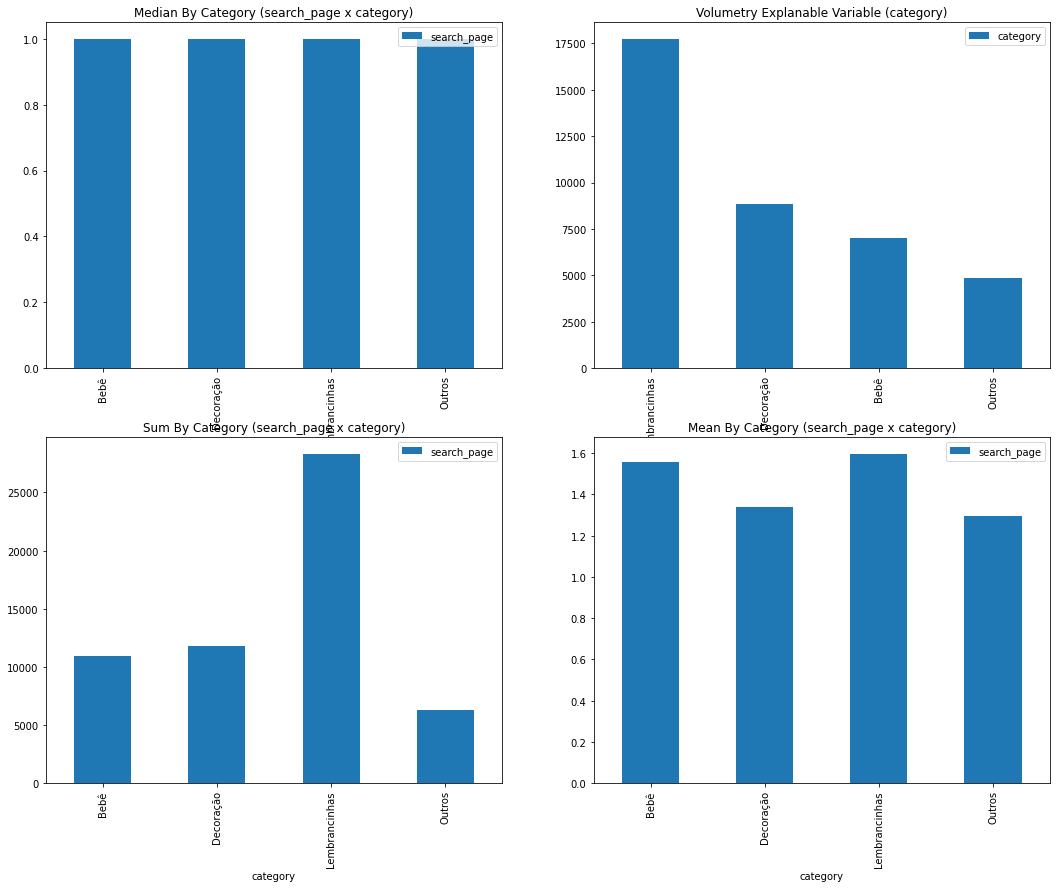

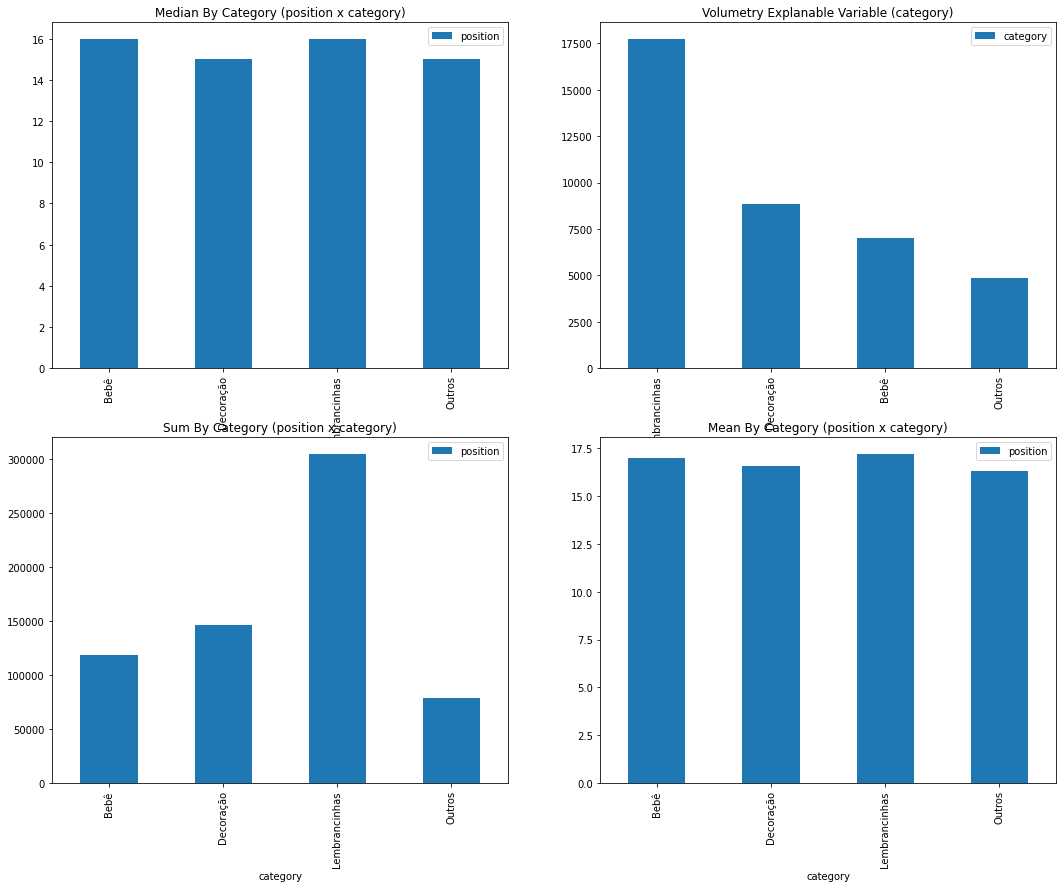

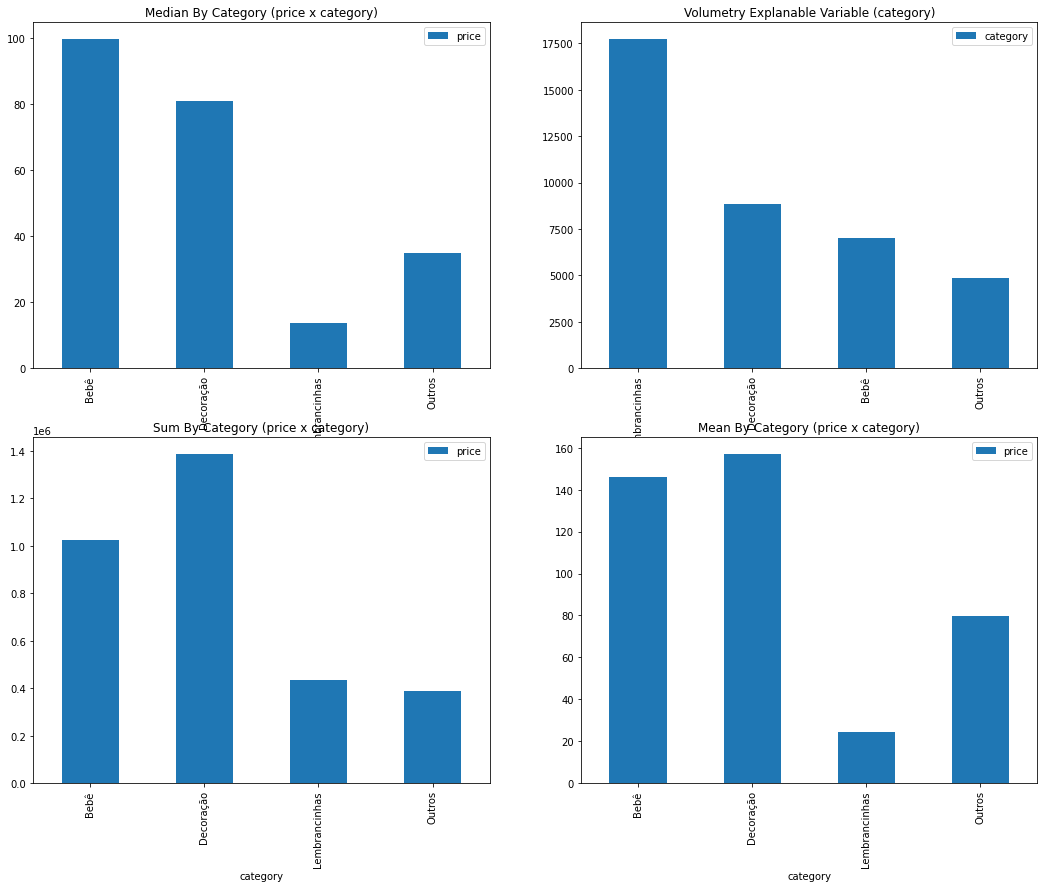

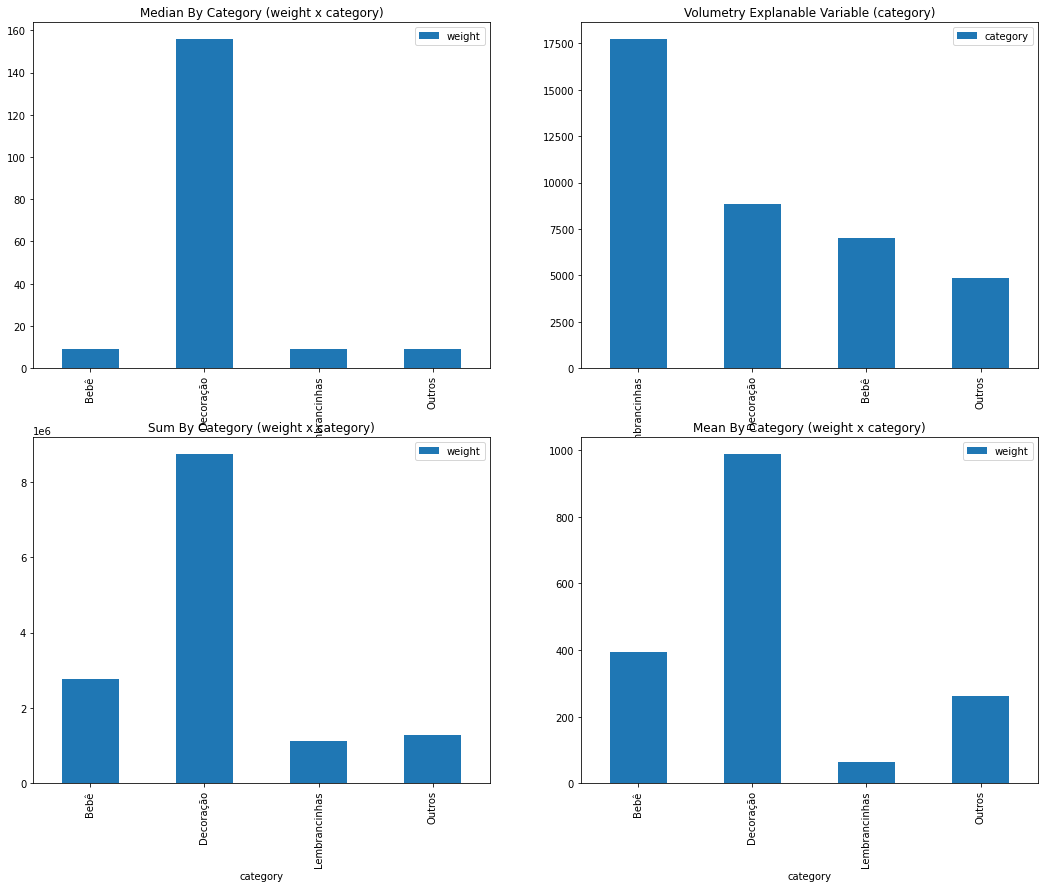

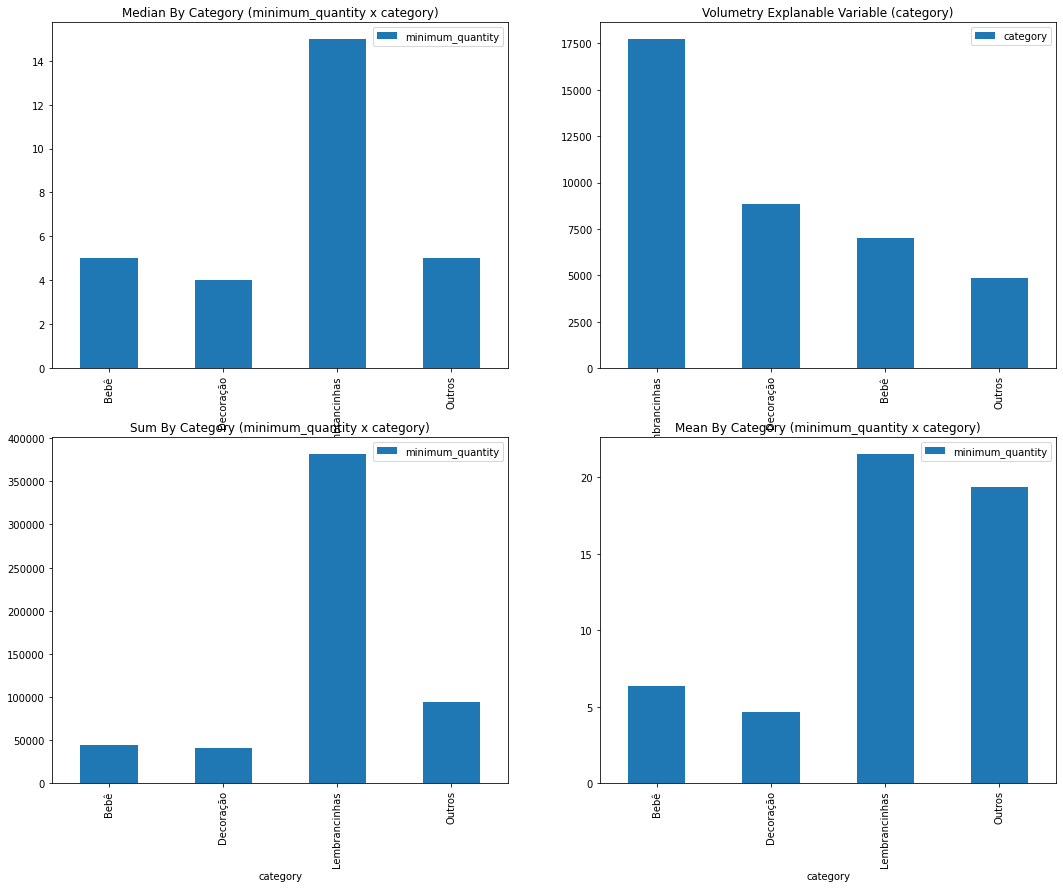

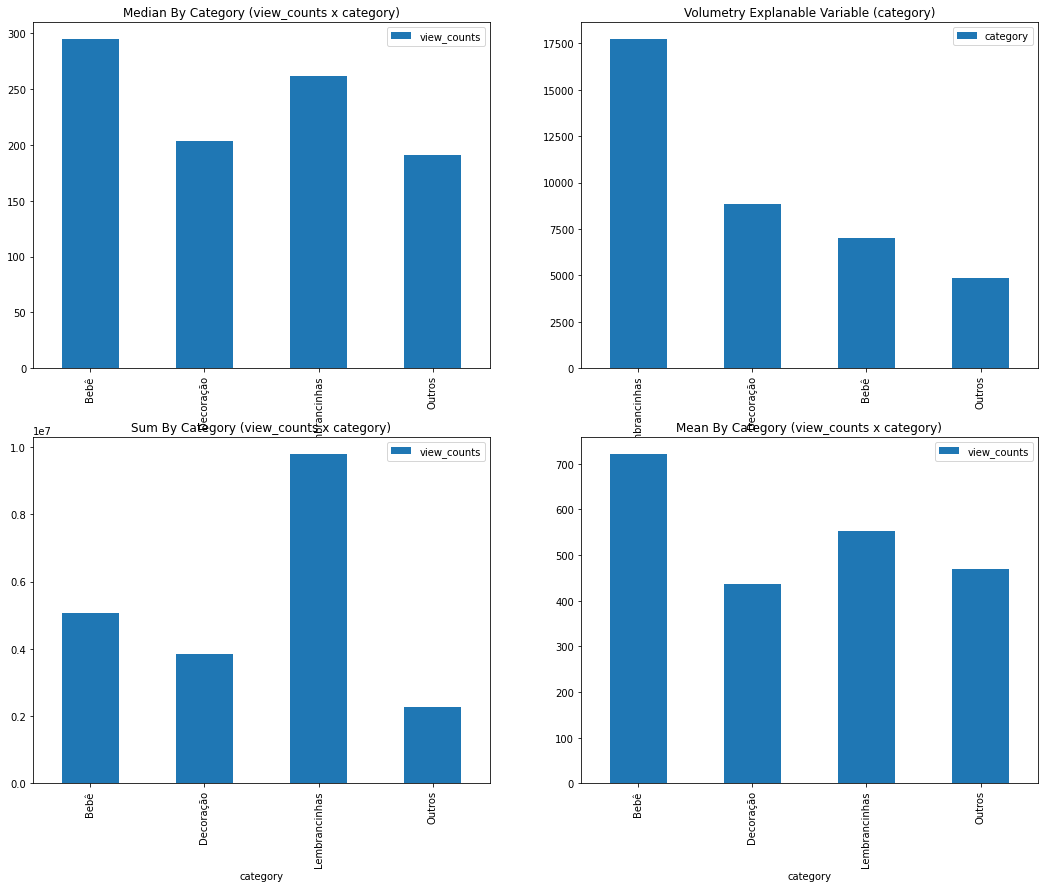

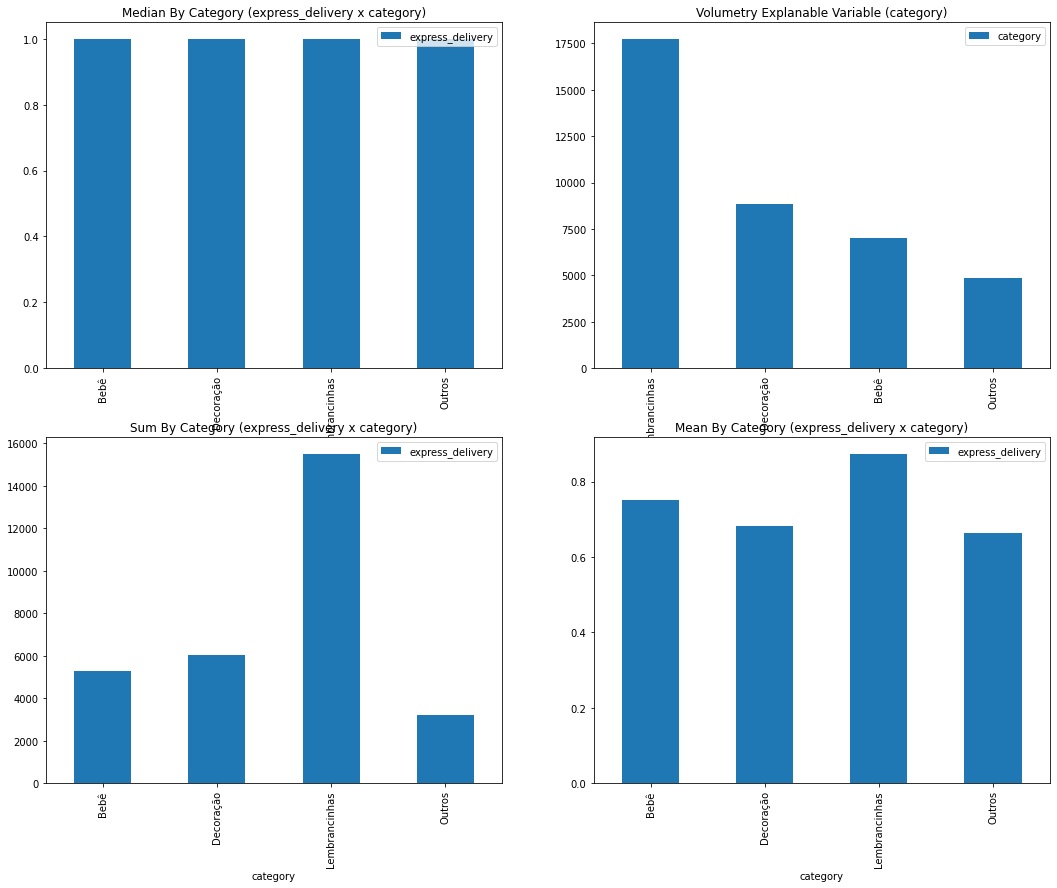

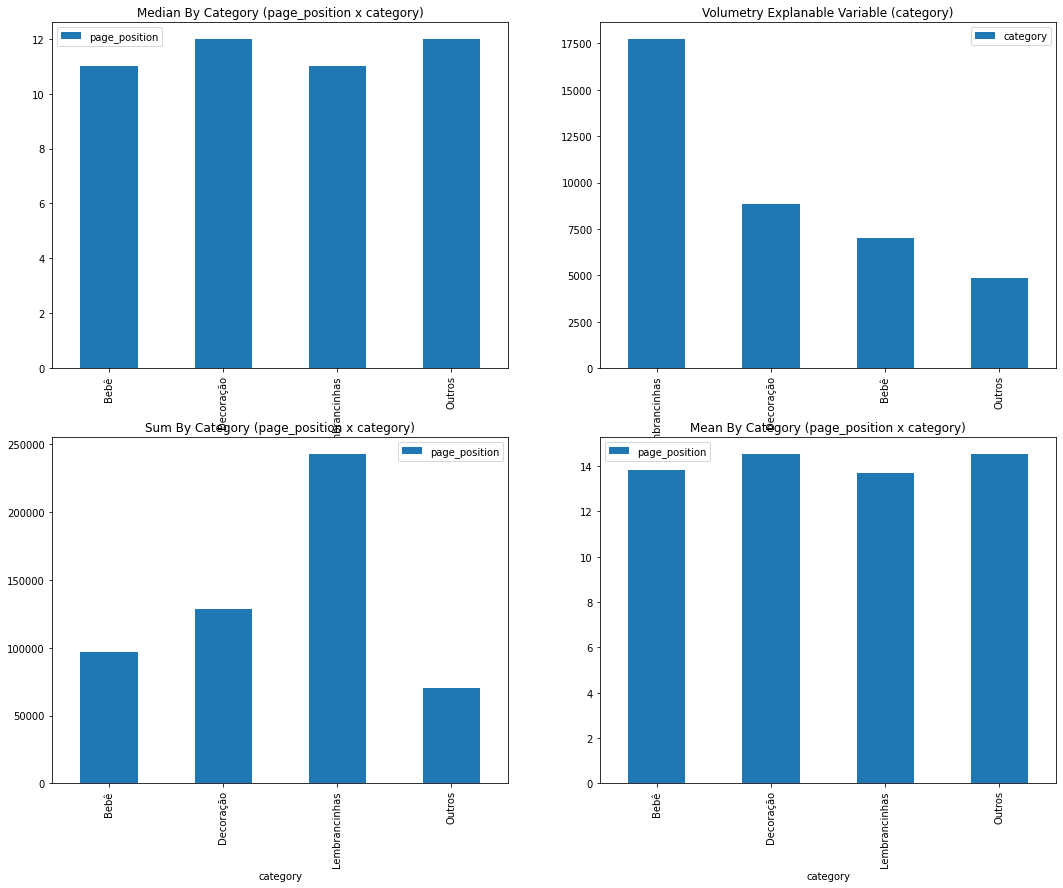

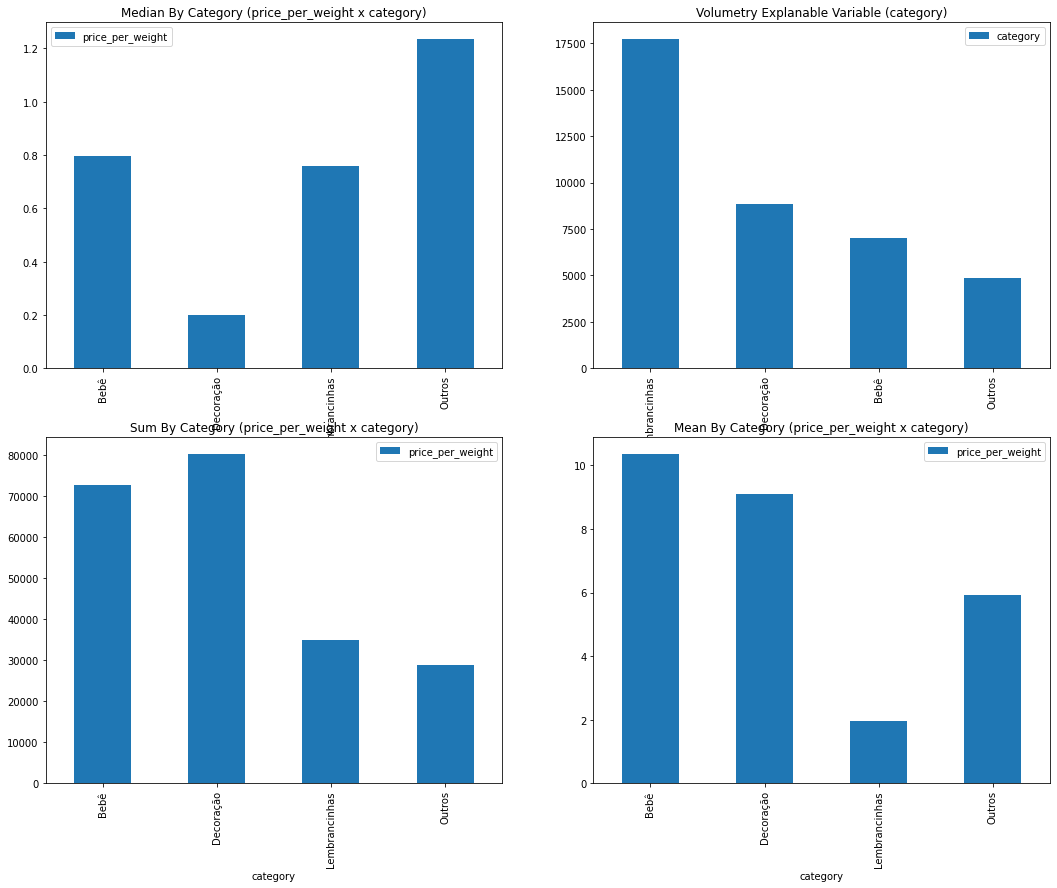

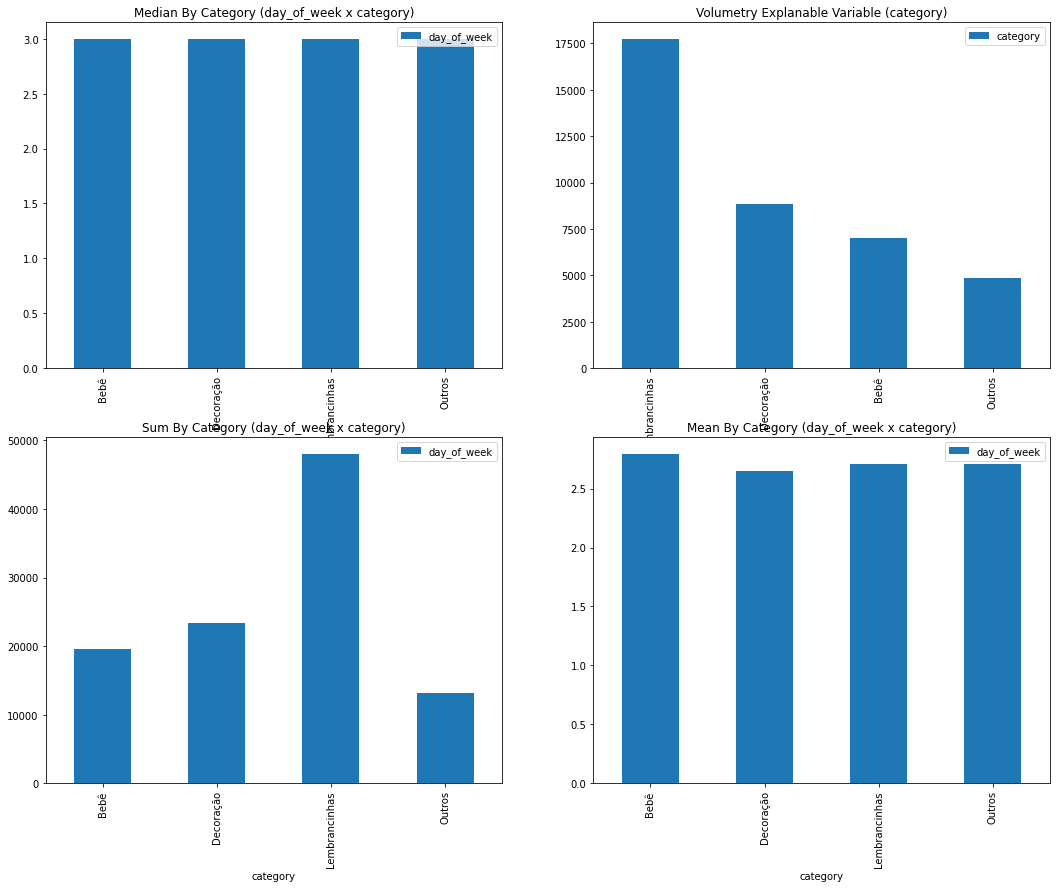

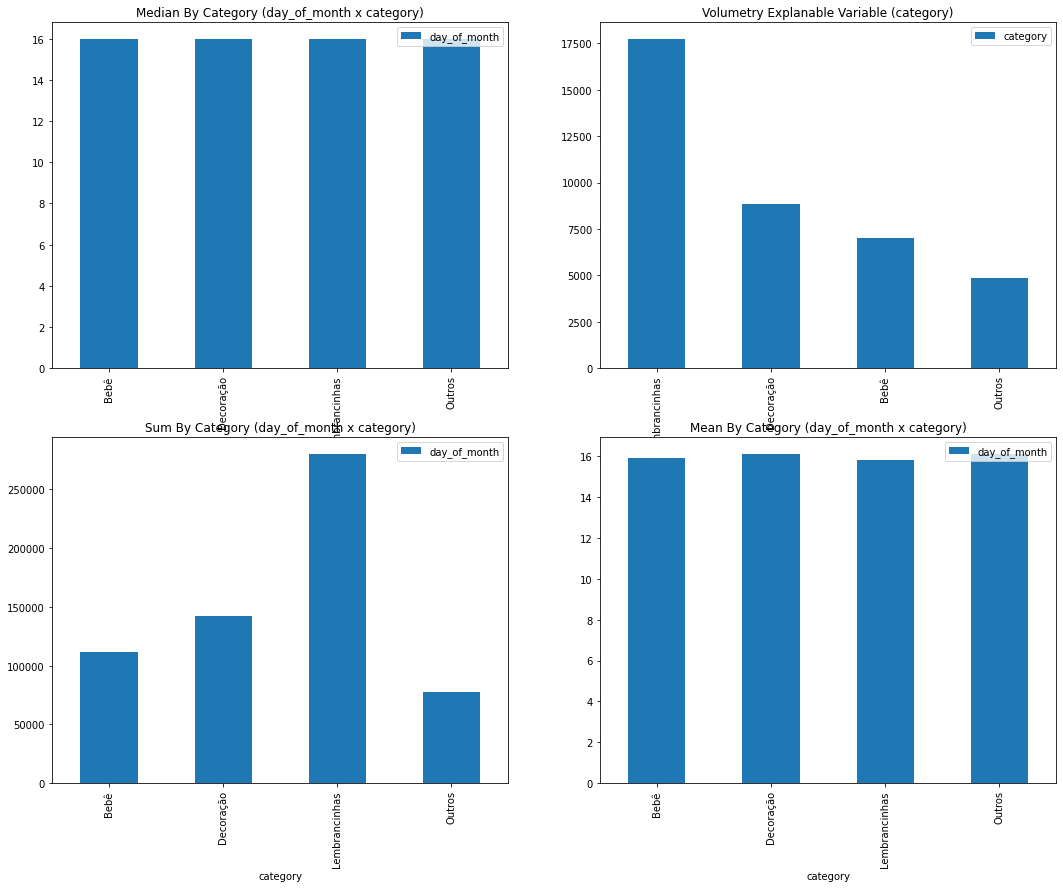

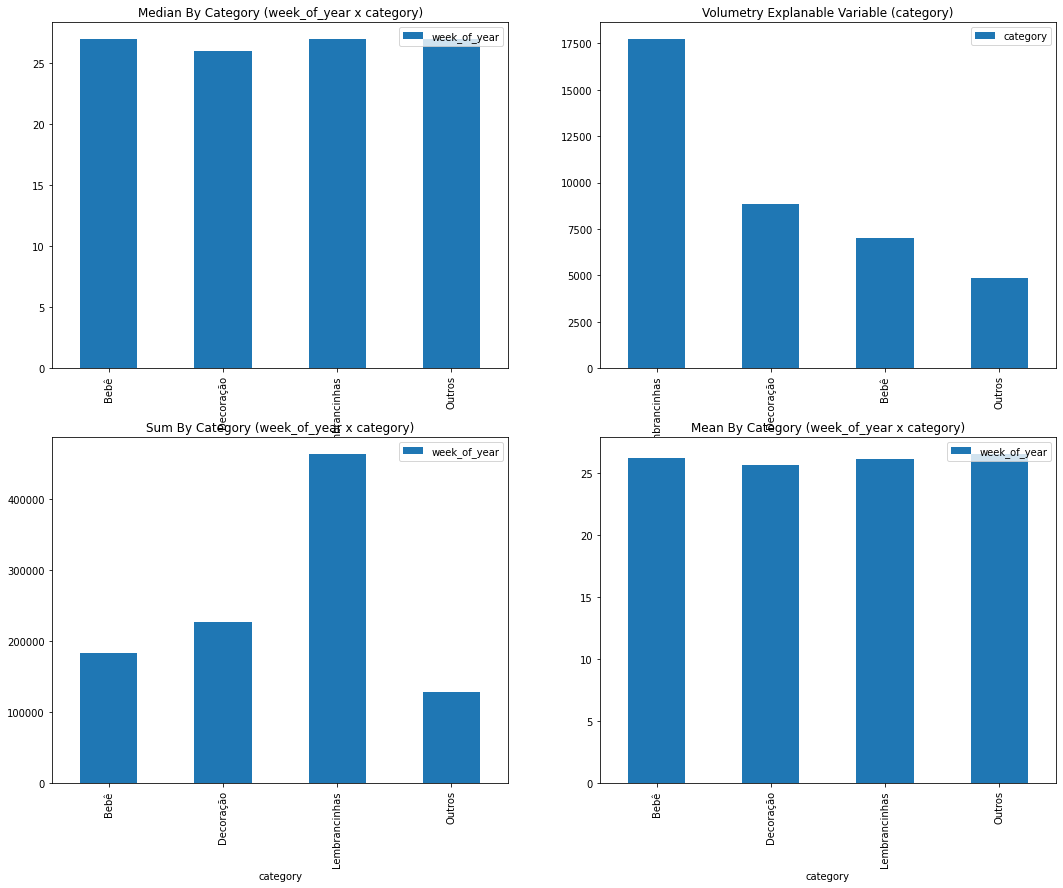

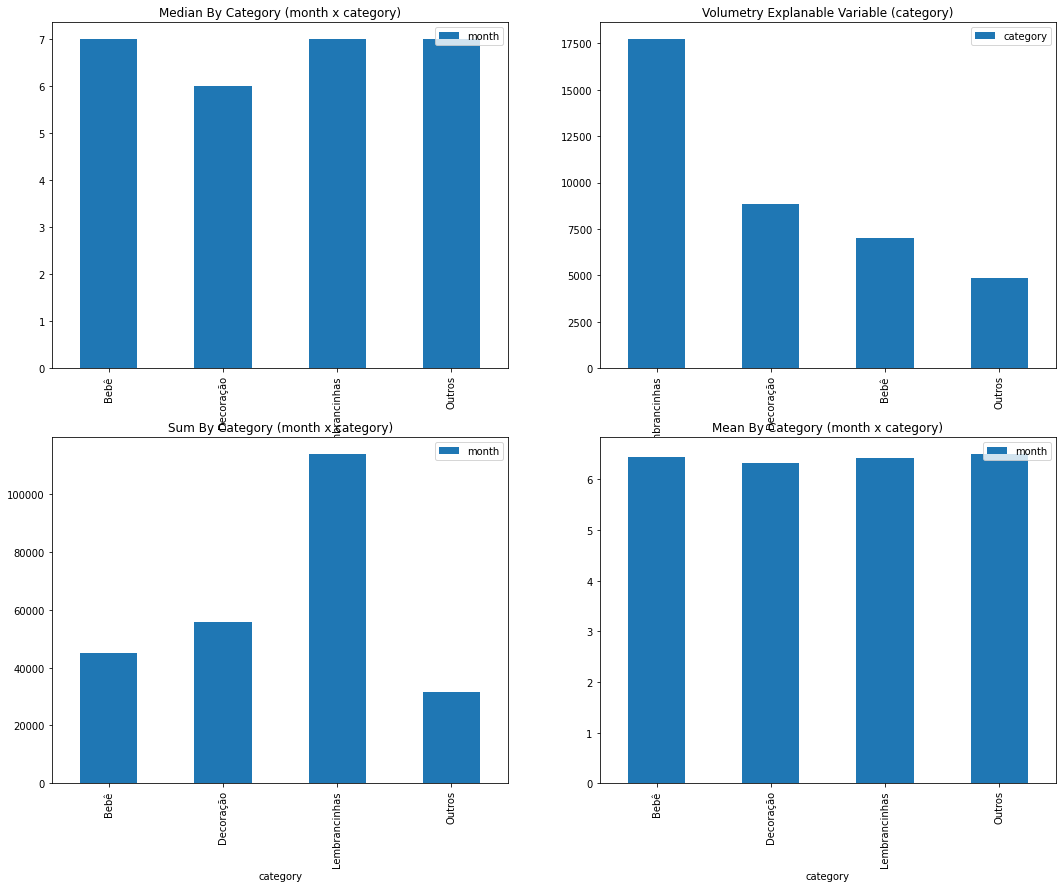

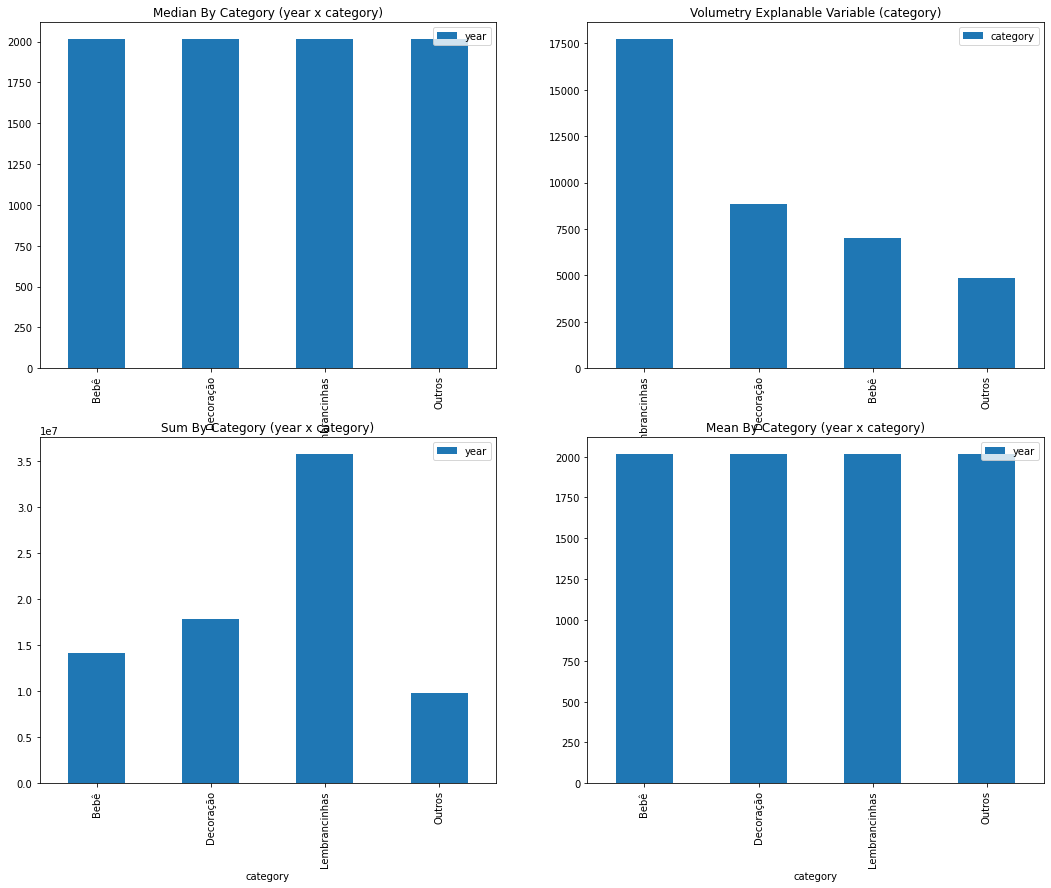

In [60]:
dataanalysis = PlotCreator(df=df1)

for expl_var in cont_list:
    saving_figloc=(c().reports_fld() / f'classification/{expl_var}_cont_eda.jpg')
    dataanalysis.plot_cat_analy(df=df1, expl_var=res_var, res_var=expl_var, categorical=True, saving_figloc=saving_figloc)

## 3.2. Keeping Cols Based in EDA

In [61]:
# these are the best columns based in EDA Analysis
keep_cols = ['product_id', 'position', 'price', 'weight', 
            'minimum_quantity', 'view_counts',
            'express_delivery', 'page_position',
            'price_per_weight', 'week_of_year',
            'category']
            
df_prepare = df1[keep_cols]

# Data Save

In [63]:
joblib.dump(df_prepare, open((c().data_proc_fld() / 'df_prepare.pkl'), 'wb'))